In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def pdf_fig(figure, filename):
    figure = figure.get_figure()
    figure.savefig("../../thesis/img/big-study/" + filename + ".pdf", bbox_inches = "tight")

In [3]:
# seaborn styling
sns.set_style("darkgrid")
sns.set_palette(sns.husl_palette(h=.5, s=1))
sns.set_context("talk")

def label_bars_ints(ax):
    for p in ax.patches:
        ax.annotate("%.0i" % np.nan_to_num(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
            textcoords='offset points')

def label_bars_floats(ax):
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
            textcoords='offset points')

def process_fig(ax, name, technique, int_annotation, hue_title):
    if (int_annotation):
        label_bars_ints(ax)
    else:
        label_bars_floats(ax)
    if (hue_title != ''):
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title=hue_title)
    pdf_fig(ax, name + '-' + technique)
    plt.show()
    ax.clear()

In [4]:
techniques = ['PBE', 'TS', 'SKWS', 'RLR']
bool_order = [True, False]

In [5]:
pbe = pd.read_csv('pbe.csv')
pbe['Technique'] = 'PBE'
ir = pd.read_csv('ir.csv')
ir['Technique'] = 'TS'
kw = pd.read_csv('keyword.csv')
kw['Technique'] = 'SKWS'
rn = pd.read_csv('random.csv')
rn['Technique'] = 'RLR'
frames = [pbe, ir, kw, rn]

result_big = pd.concat(frames)
result_big.rename(columns={'Unnamed: 0':'v',
                       'Accuracy':'String Distance',
                       'TestOutput':'Test Output',
                       'DesiredTestOutput':'Desired Test Output',
                       'ExampleCount':'Example Count',
                       'TestInputLineCount':'Test Input Line Count',
                       'TestCategory':'Test Category',
                       'ContextSizeFactor':'Context Size Factor',
                       'LearningDuration':'Learning Duration',
                       'ApplicationDuration':'Application Duration'}, inplace=True)

def calc_overlapping_lines(row):
    lines_desired = str(row['Desired Test Output']).splitlines()
    lines_output = str(row['Test Output']).splitlines()
    overlap = list((Counter(lines_output) & Counter(lines_desired)).elements())
    row['True Positives Count'] = len(overlap)
    row['False Positives Count'] = len(lines_output) - len(overlap)
    row['False Negatives Count'] = len(lines_desired) - len(overlap)
    row['Output Lines Count'] = len(lines_output)
    row['Desired Lines Count'] = len(lines_desired)
    return row

result_big = result_big.apply(calc_overlapping_lines, axis=1)
result_big['True Negatives Count'] = result_big['Test Input Line Count'] - (result_big['Output Lines Count'] + result_big['False Negatives Count'])
result_big['All Desired Lines Extracted'] = result_big['False Negatives Count'] == 0
result_big['Precision'] = result_big['True Positives Count'] / result_big['Output Lines Count']
result_big['Recall'] = result_big['True Positives Count'] / result_big['Desired Lines Count']
result_big['Accuracy'] = (result_big['True Positives Count'] + result_big['True Negatives Count']) / result_big['Test Input Line Count']

def category_count(categories):
    return len(set(categories.split('-')))

result_big['Category Count'] = result_big.apply(lambda x : category_count(x['Categories']), axis=1)
result_big['Single Category'] = result_big['Category Count'] == 1

result_big.head()

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,String Distance,IoU,Successful,Learning Duration,...,False Negatives Count,Output Lines Count,Desired Lines Count,True Negatives Count,All Desired Lines Extracted,Precision,Recall,Accuracy,Category Count,Single Category
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.0,False,00.24.078,...,29,1,29,3226,False,0.0,0.0,0.990786,1,True
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.08.105,...,15,1,15,3080,False,0.0,0.0,0.994832,2,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.12.899,...,15,1,15,3110,False,0.0,0.0,0.994882,2,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.17.907,...,15,1,15,3065,False,0.0,0.0,0.994807,2,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.22.948,...,15,1,15,3071,False,0.0,0.0,0.994817,2,False


In [6]:
result_big.dtypes

v                                int64
Example Count                    int64
LearnedProgram                  object
TestInputPath                   object
Test Output                     object
Desired Test Output             object
String Distance                float64
IoU                            float64
Successful                        bool
Learning Duration               object
Application Duration            object
SearchKeywords                  object
AllKeywords                     object
Categories                      object
Test Input Line Count            int64
Test Category                    int64
Context Size Factor            float64
Technique                       object
True Positives Count             int64
False Positives Count            int64
False Negatives Count            int64
Output Lines Count               int64
Desired Lines Count              int64
True Negatives Count             int64
All Desired Lines Extracted       bool
Precision                

In [7]:
result = result_big[result_big['Context Size Factor'] == 1]
result.head()

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,String Distance,IoU,Successful,Learning Duration,...,False Negatives Count,Output Lines Count,Desired Lines Count,True Negatives Count,All Desired Lines Extracted,Precision,Recall,Accuracy,Category Count,Single Category
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.0,False,00.24.078,...,29,1,29,3226,False,0.0,0.0,0.990786,1,True
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.08.105,...,15,1,15,3080,False,0.0,0.0,0.994832,2,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.12.899,...,15,1,15,3110,False,0.0,0.0,0.994882,2,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.17.907,...,15,1,15,3065,False,0.0,0.0,0.994807,2,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.22.948,...,15,1,15,3071,False,0.0,0.0,0.994817,2,False


In [8]:
def rtf(result,technique):
    return result[result['Technique'] == technique]

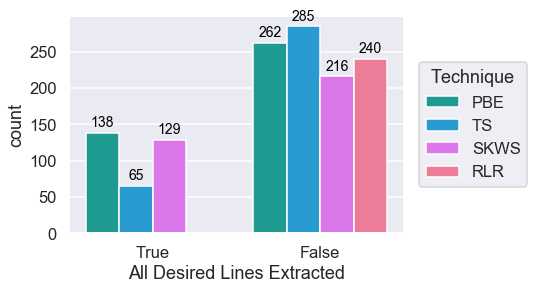

In [9]:
# all techniques - extracted desired log part
ax = sns.countplot(x='All Desired Lines Extracted', hue='Technique', data=result, order=bool_order)
process_fig(ax, 'success', 'all', True, 'Technique')

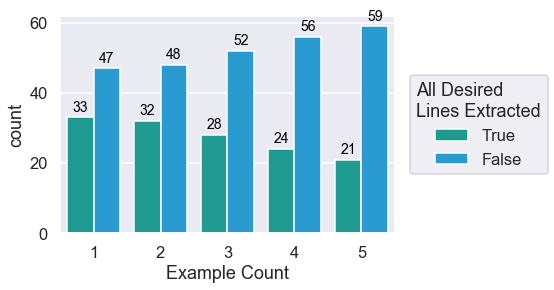

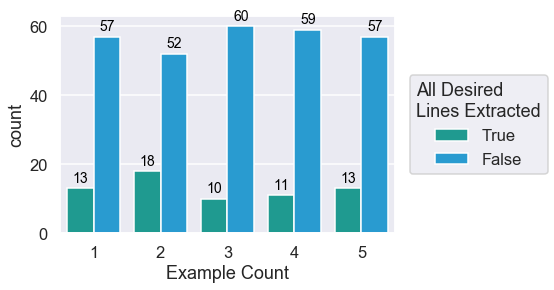

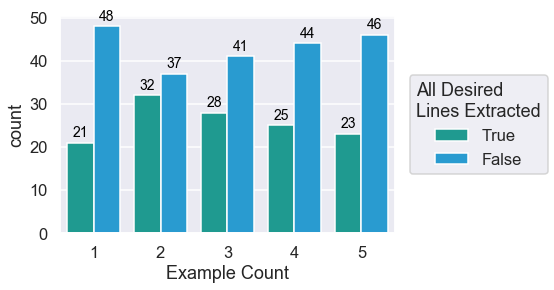

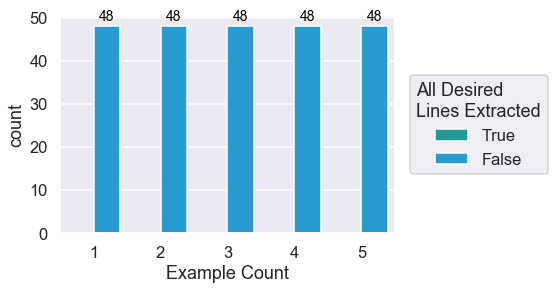

In [10]:
# separate technique success rate against number of examples
#ax = sns.catplot(x='ExampleCount', col='Technique', hue = 'AllDesiredExtracted',
#                 data=result, kind='count')
def plot_examples_success_technique(technique):
    ax = sns.countplot(x='Example Count', hue='All Desired Lines Extracted',
                  data=rtf(result,technique), hue_order=bool_order)
    process_fig(ax, 'success-examples', technique, True, 'All Desired\nLines Extracted')

for technique in techniques:
    plot_examples_success_technique(technique)

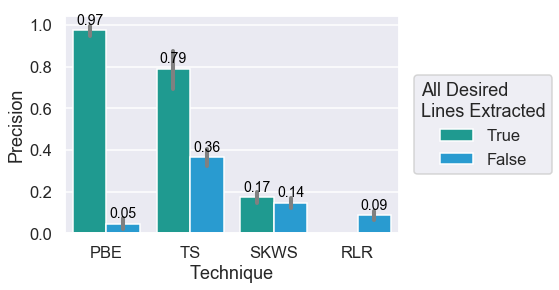

In [11]:
# precision of extraction: how much of the extracted text is actually necessary
ax = sns.barplot(x='Technique', y='Precision', hue='All Desired Lines Extracted', data=result, hue_order=bool_order, errcolor='grey')
process_fig(ax, 'precision', 'all', False, 'All Desired\nLines Extracted')

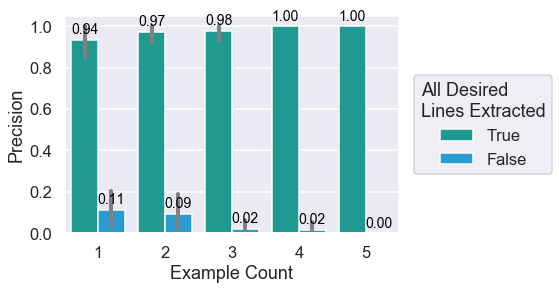

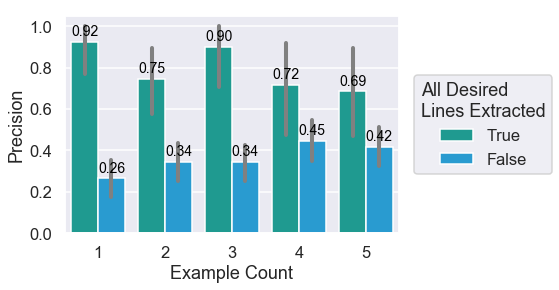

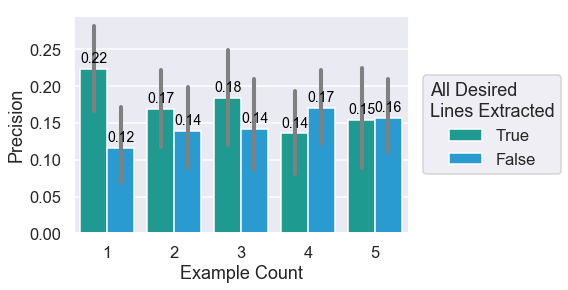

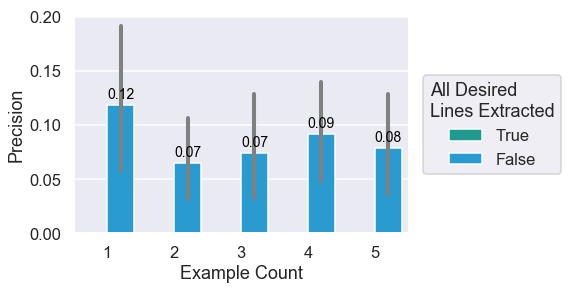

In [12]:
# precision one technique against example count
def precision_examples(technique):
    ax = sns.barplot(x='Example Count', y='Precision', hue='All Desired Lines Extracted', data=rtf(result, technique), hue_order=bool_order, errcolor='grey')
    process_fig(ax, 'precision', technique, False, 'All Desired\nLines Extracted')

for technique in techniques:
    precision_examples(technique)

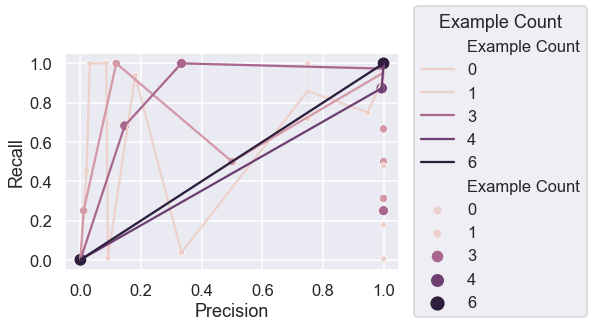

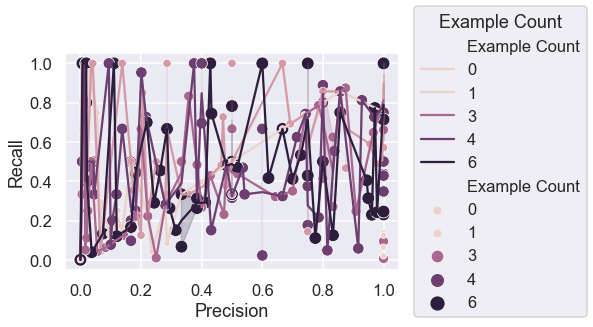

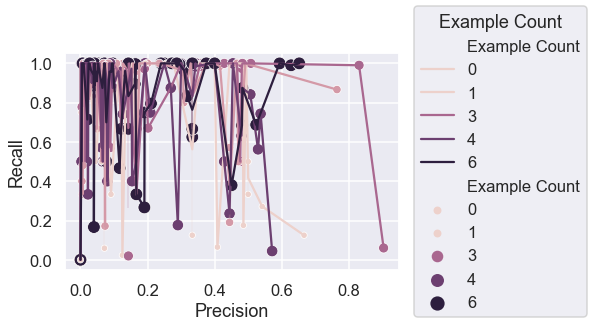

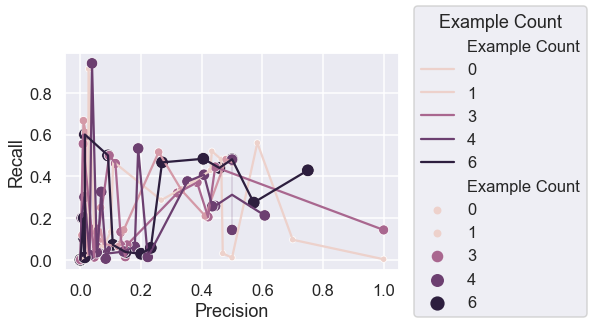

In [13]:
# recall one technique against example count
def precision_examples(technique):
    ax = sns.scatterplot(x='Precision',
                         y='Recall',
                         size='Example Count',
                         hue='Example Count',
                         data=rtf(result, technique),
                         hue_order=bool_order,
                         hue_norm=(1, 5))
    ax = sns.lineplot(x='Precision',
                         y='Recall',
                         hue='Example Count',
                         data=rtf(result, technique),
                         hue_order=bool_order)
    process_fig(ax, 'recall-precision', technique, False, 'Example Count')

for technique in techniques:
    precision_examples(technique)

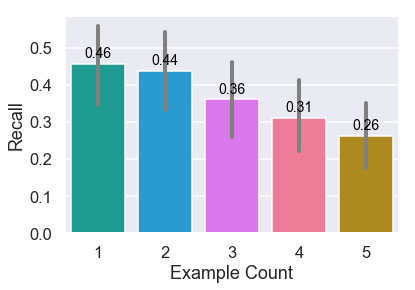

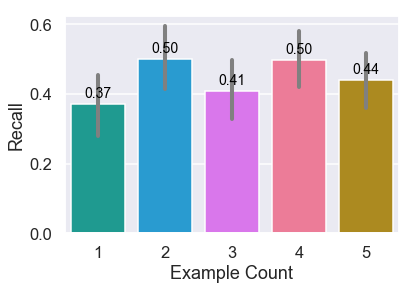

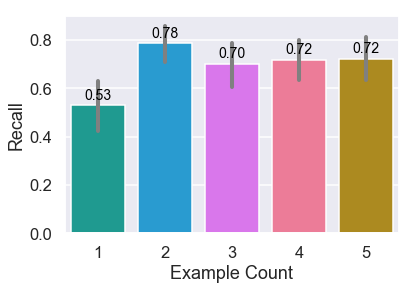

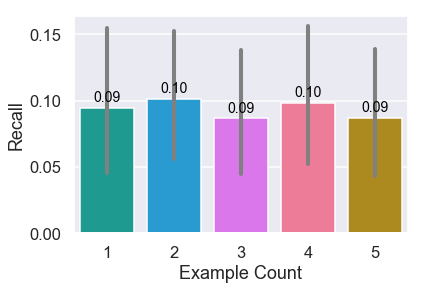

In [14]:
# precision one technique against example count
def precision_examples(technique):
    ax = sns.barplot(x='Example Count', y='Recall', data=rtf(result, technique), hue_order=bool_order, errcolor='grey')
    process_fig(ax, 'recall', technique, False, '')

for technique in techniques:
    precision_examples(technique)

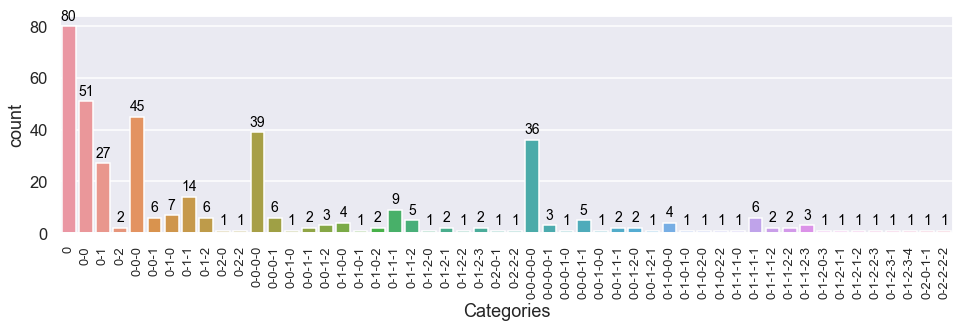

In [15]:
# category distribution
pbe_result = rtf(result, 'PBE')
plt.figure(figsize=(16,4))
order = list(set(pbe_result['Categories']))
order.sort()
order.sort(key = len)
ax = sns.countplot(x='Categories', data=pbe_result, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=13, horizontalalignment='center')
process_fig(ax, 'categories', 'dataset', True, '')

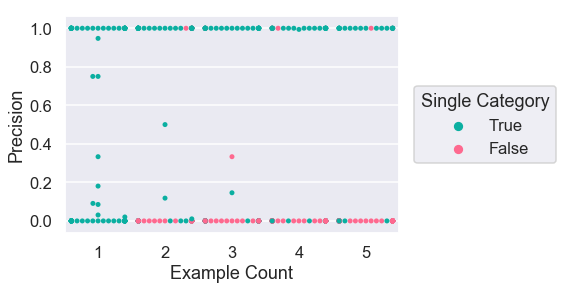

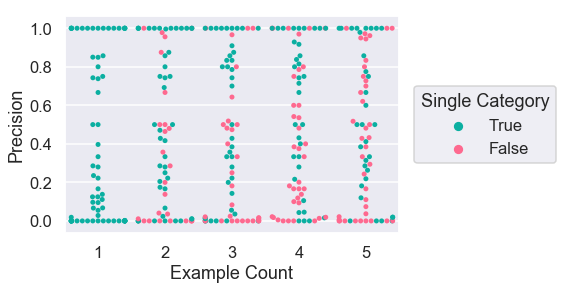

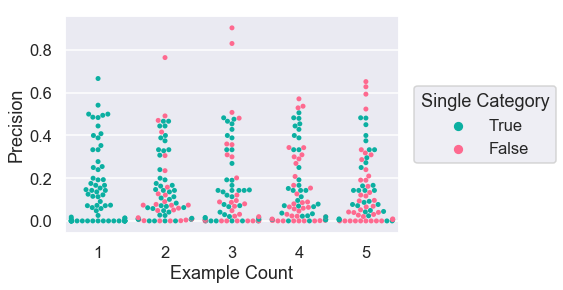

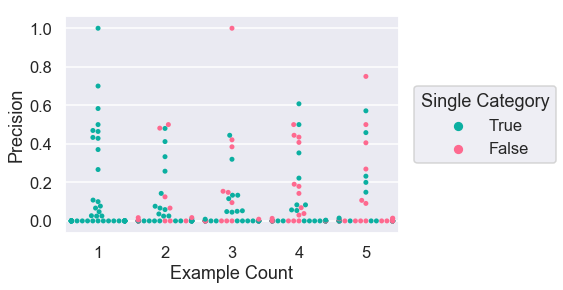

In [16]:
# precision one technique against example count
def precision_examples(technique):
    ax = sns.swarmplot(x='Example Count',
                       y='Precision',
                       hue='Single Category',
                       data=rtf(result, technique),
                       hue_order=bool_order,
                       palette=sns.husl_palette(2, h=.5, s=1))
    process_fig(ax, 'precision-singlecategory-swarm', technique, False, 'Single Category')

for technique in techniques:
    precision_examples(technique)

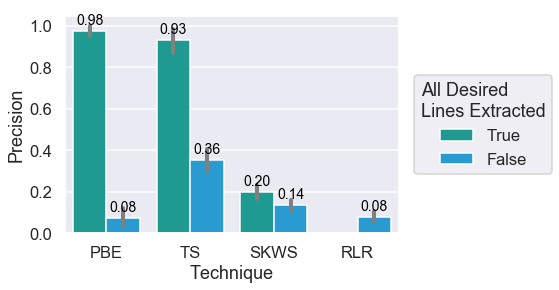

In [17]:
# single-category-precsion
result_single_category = result[result['Single Category']]
ax = sns.barplot(x='Technique',
                 y='Precision',
                 hue='All Desired Lines Extracted',
                 data=result_single_category,
                 hue_order=bool_order,
                 errcolor='grey')
process_fig(ax, 'single-cateogry-precision', 'all', False, 'All Desired\nLines Extracted')

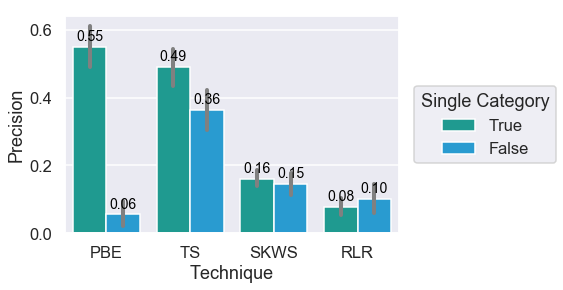

In [18]:
# single category vs. multiple
ax = sns.barplot(x='Technique', y='Precision', hue='Single Category', data=result, hue_order=bool_order, errcolor='grey')
process_fig(ax, 'precision-category-singularity', 'all', False, 'Single Category')

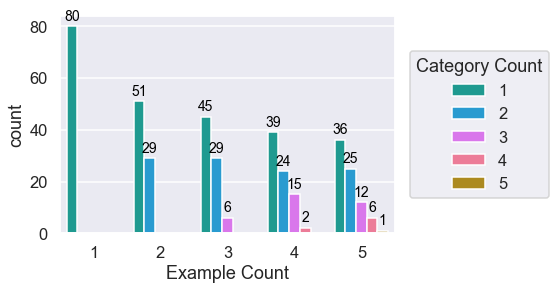

In [19]:
# category count
ax = sns.countplot(x='Example Count', hue='Category Count', data=rtf(result, 'PBE'))
process_fig(ax, 'categorycount-examplecount', 'dataset', True, 'Category Count')

In [20]:
# category count vs example count
# ax = sns.barplot(x='ExampleCount', y='CategoryCount', data=rtf(result, 'pbe'))
# process_fig(ax, 'categorycount-examplecount', 'dataset', False, '')

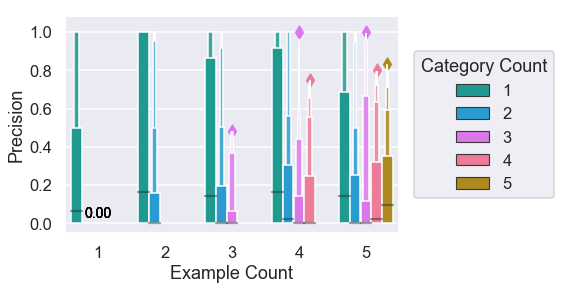

In [21]:
ax = sns.boxenplot(x='Example Count', y='Precision', hue='Category Count', data=result)
process_fig(ax, 'precision-categorycount-examplecount', 'all', False, 'Category Count')

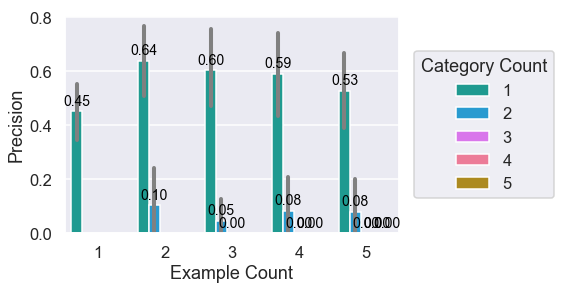

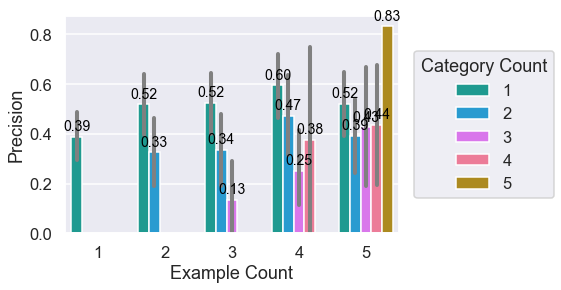

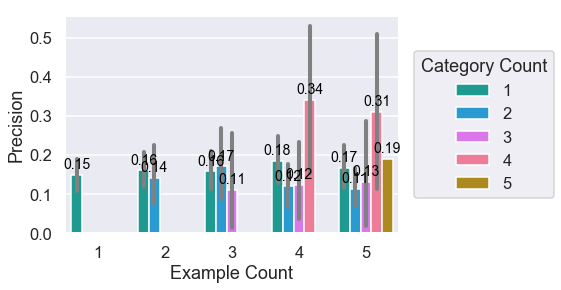

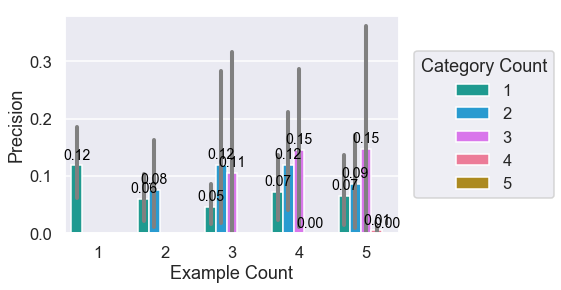

In [22]:
def example_count_category_count_precision(technique):
    ax = sns.barplot(x='Example Count', y='Precision', hue='Category Count', data=rtf(result, technique), errcolor='grey')
    process_fig(ax, 'precision-categorycount-examplecount', technique, False, 'Category Count')

for technique in techniques:
    example_count_category_count_precision(technique)

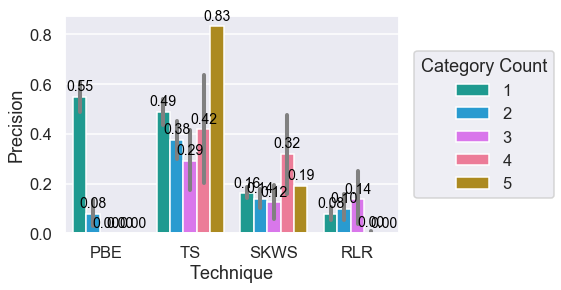

In [23]:
# example count category comparing techniques in one picture
ax = sns.barplot(x='Technique', y='Precision', hue='Category Count',
                 data=result, errcolor='grey')
process_fig(ax, 'categorycount-precision', 'all', False, 'Category Count')

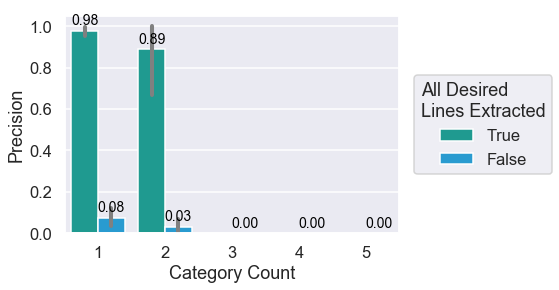

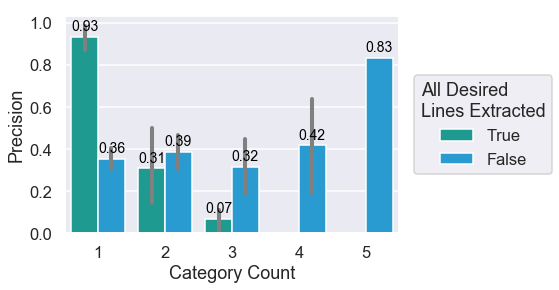

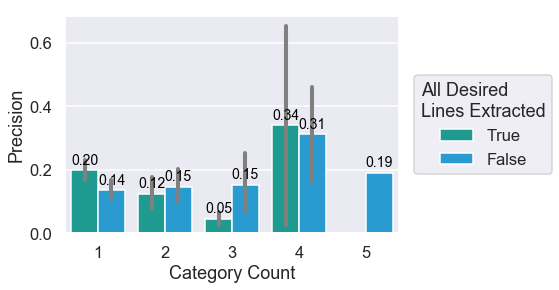

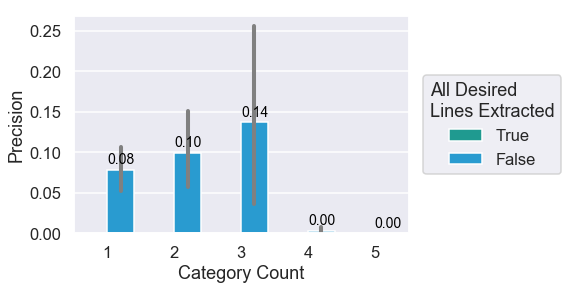

In [24]:
# success of extractions against category counts
def example_count_success(technique):
    ax = sns.barplot(x='Category Count', y='Precision', hue='All Desired Lines Extracted',
                  data=rtf(result, technique), hue_order=bool_order, errcolor='grey')
    process_fig(ax, 'categorycount-success', technique, False, 'All Desired\nLines Extracted')
    
for technique in techniques:
    example_count_success(technique)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



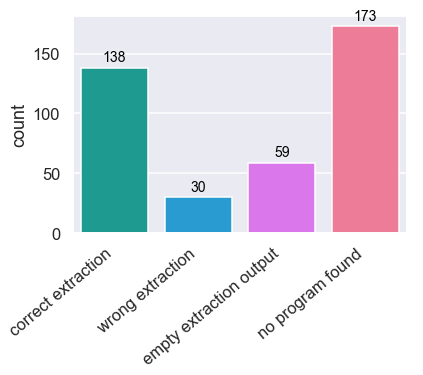

In [25]:
# pbe: if the extraction failed, why did it fail? (when was no program learned/regex did not match?)
# failed = result[(result['All Desired Lines Extracted'] == False) & (result.Technique == 'PBE')]
# failed_pbe = failed
failed = rtf(result, 'PBE')
failed.loc[failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = failed['Test Output']
failed.loc[~failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = 'wrong extraction'
failed.loc[(failed['to'] == 'wrong extraction') & (failed['All Desired Lines Extracted'] == True), 'to'] = 'correct extraction'
failed.loc[failed['to'] == 'no extraction found for this input', 'to'] = 'empty extraction output'
pbe_fail_order = ['correct extraction', 'wrong extraction', 'empty extraction output', 'no program found']

ax = sns.countplot(x="to", data=failed, order=pbe_fail_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('')
process_fig(ax, 'failure-reason', 'PBE', True, '')

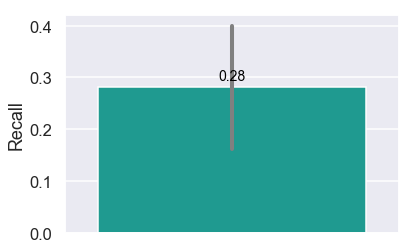

In [26]:
ax = sns.barplot(y='Recall', errcolor='grey', data=failed[failed['to'].isin(['wrong extraction'])])
process_fig(ax, 'recall-examplecount-wrongextaction', 'PBE', False, '')

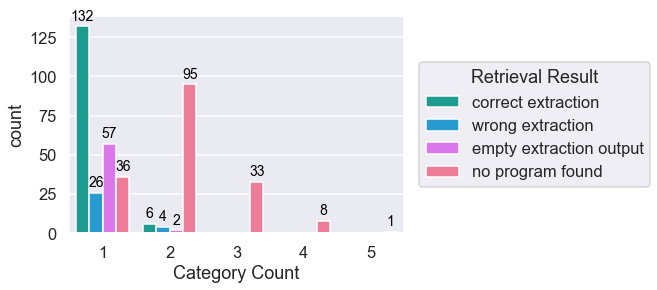

In [27]:
# pbe failure reason against category count
ax = sns.countplot(x='Category Count', hue='to', data=failed, hue_order=pbe_fail_order)
process_fig(ax, 'failure-reason-categorycount', 'PBE', True, 'Retrieval Result')

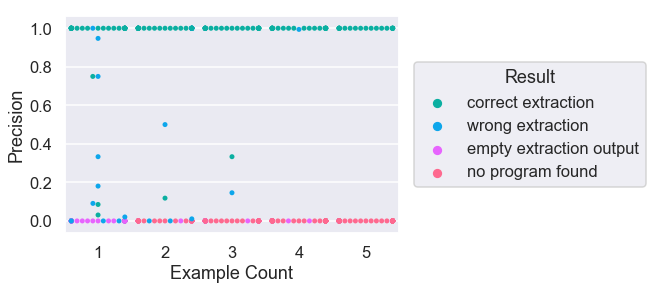

In [28]:
# precision one technique against example count
ax = sns.swarmplot(x='Example Count', y='Precision', hue='to', data=failed, hue_order=pbe_fail_order)
process_fig(ax, 'precision-extraction-result', 'PBE', False, 'Result')

In [29]:
# timed_result = result
# timed_result['Learning Duration'] = pd.to_datetime(result['Learning Duration'],format='%M.%S.%f') - pd.Timestamp('1900-01-01 00:00:00.000')
# timed_result['Application Duration'] = pd.to_datetime(result['Application Duration'],format='%M.%S.%f') - pd.Timestamp('1900-01-01 00:00:00.000')

In [30]:
#timed_result.head()

In [31]:
# # learning & application duration for all,
# ax = sns.barplot(x='Technique', y='Learning Duration', data=timed_result)
# process_fig(ax, 'learning-duration', 'all', False, '')

# ax = sns.barplot(x='Technique', y='Application Duration', data=timed_result)
# process_fig(ax, 'application-duration', 'all', False, '')

# # learning duration for pbe,
# ax = sns.barplot(x='Example Count', y='Learning Duration',
#                  hue='Category Count', data=rtf(timed_result, 'PBE'))
# process_fig(ax, 'learning-duration-examplecount', 'pbe', False, 'Category Count')

# # learning duration for pbe per type?

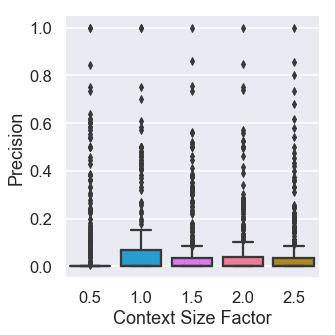

In [32]:
# compare context factor size for techniques
#def context_factor_size_precision(technique):
    
ax = sns.catplot(x='Context Size Factor', y='Precision', data=rtf(result_big, 'RLR'), kind='box')

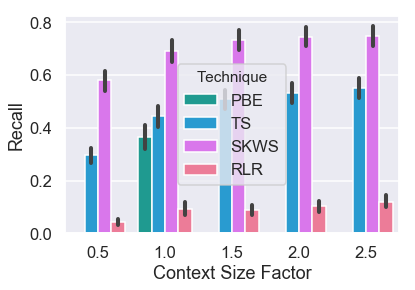

In [33]:

ax = sns.barplot(x='Context Size Factor', y='Recall', hue='Technique', data=result_big)

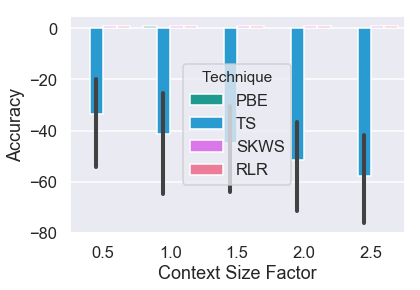

In [34]:
ax = sns.barplot(x='Context Size Factor', y='Accuracy', hue='Technique', data=result_big)

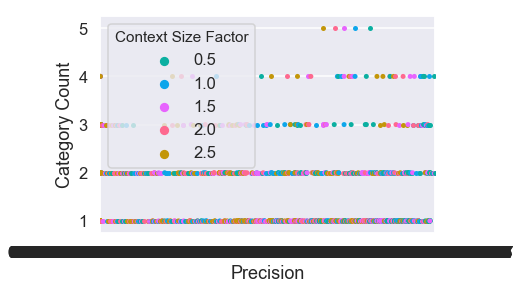

In [35]:
ax = sns.stripplot(x='Precision', y='Category Count', hue='Context Size Factor', data=rtf(result_big, 'SKWS'))